In [75]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [49]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import fits
import astropy.units as u

%matplotlib inline

In [3]:
datapath = '../../../Dropbox/ARCUS/raysforJoern/'

In [4]:
datafiles = glob(os.path.join(datapath, '*'))

In [18]:
# Find files with no offset
d0 = [d for d in datafiles if ((fits.getheader(d,0)['OFFX']==0) and ((fits.getheader(d,0)['OFFY']==0)))]

In [20]:
d0.sort()

In [50]:
energies = list(set([fits.getheader(d, 0)['ENERGY'] for d in d0]))
energies.sort()
energies= np.array(energies)
wave = (energies * u.keV).to(u.Angstrom, equivalencies=u.spectral())
orders = np.arange(13)


In [61]:
prob = np.zeros((len(energies), len(orders)))
n = np.zeros_like(prob)

In [73]:
for d in d0:
    hdus = fits.open(d)
    e = np.argmin(np.abs(hdus[0].header['ENERGY'] - energies))
    o = int(np.abs(hdus[0].header['ORDER']))
    try:
        prob[e, o] = np.sum(hdus[1].data['PROBABILITY'])  / hdus[0].header['NPHOTONS']
        n[e, o] = len(hdus[1].data['PROBABILITY'])
    except KeyError:
        pass  # old file that was not deleted before new run

## This is the plot Joern had originally
We discussed it during the telecon before the last one. It gives equal weight to all photons. (Remember the discussion on the "box of the dash-dotted line"?)

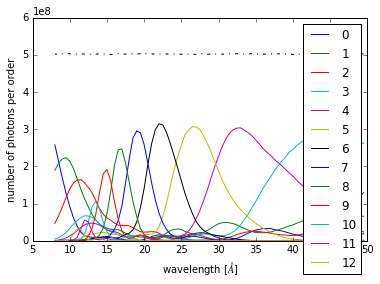

In [76]:
for i in range(len(orders)):
    plt.plot(wave, n[:, i] * 1428.5 * 4, label=i)

plt.plot(wave, n[:, :].sum(axis=1) * 1428.5 * 4, 'k', ls='-.')
plt.legend()
plt.xlabel('wavelength [$\AA$]')
plt.ylabel('number of photons per order')

## Plot that Jorn had most recently
(Actually, almost but not quite, the plot the Joern had most recently. If you zoom in enough you'll see differences because I re-run my simulations and because they are Monte-Carlo, there is some numericla noise.)

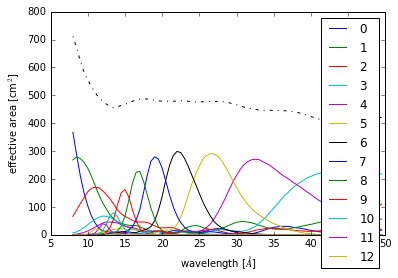

In [78]:
for i in range(len(orders)):
    plt.plot(wave, prob[:, i] * 1428.5 * 4, label=i)

plt.plot(wave, prob[:, :].sum(axis=1) * 1428.5 * 4, 'k', ls='-.')
plt.legend()
plt.xlabel('wavelength [$\AA$]')
plt.ylabel('effective area [cm$^2$]')

## Now, we multiply with the filters and CCD QE

In [68]:
# Add location of arcus definitions to path (unless in same directory).
# Not found automatically, because I did not install it as a module.
import sys
sys.path.append('..')
import arcus.arcus as arcus

In [69]:
filt = arcus.filtersandqe.filterfunc(energies)

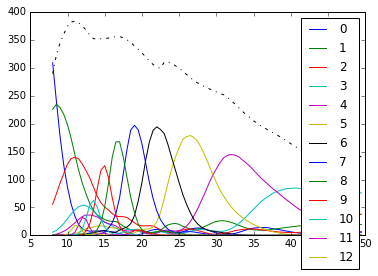

In [80]:
for i in range(len(orders)):
    plt.plot(wave, prob[:, i] * 1428.5 * 4 *filt, label=i)

plt.plot(wave, prob[:, 1:].sum(axis=1) * 1428.5 * 4 * filt, 'k', ls='-.')
plt.legend()

This now looks already very similar to the effective area plot in the proposal and in [the notebook I showed you before](http://nbviewer.jupyter.org/github/hamogu/ARCUS/blob/master/notebooks/CATmerrit.ipynb). However, the numbers are exactly a factor fo 2 too low. So, I checked my ``run_joern.py`` code again, and, voila, it only write one trace instead of both to the fits files.